In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Define functions for later use

In [2]:
# Get Scaled data
def scale_data(X_Training, X_Testing):
    sc = StandardScaler()
    sc.fit(X_Training)
    X_Training_std = sc.transform(X_Training)
    X_Testing_std = sc.transform(X_Testing)
    return X_Training_std, X_Testing_std

# Logistic Regression
def run_logistic_regression(X_Training, X_Testing, y_Training):
    logreg = LogisticRegression()
    logreg.fit(X_Training, y_Training)
    y_Predicted = logreg.predict(X_Testing)
    return y_Predicted

# K-nearest neighbors

# Random Forest Classifier

# Preprocessing

In [3]:
#test_data = pd.read_csv('../input/test.csv') # 418 rows test_data.describe()
#train_data = pd.read_csv('../input/train.csv') # 891 rows train_data.describe()
test_data = pd.read_csv('test.csv') # 418 rows test_data.describe()
train_data = pd.read_csv('train.csv') # 891 rows train_data.describe()

In [4]:
test_data.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


The testing set does not have information on whether the passenger survived. Therefore, we need to also train/test on the training data. 

## Columns in Training Data
+ PassengerId - numeric (DROP)
+ Survived - 0 or 1 
+ PClass - Numeric
+ Name - String (DROP)
+ Sex - String (male/female)
+ Age - numeric
+ SibSp - 0 or 1
+ Parch - ?
+ Ticket - DROP
+ Fare - numeric
+ Cabin 
+ Embarked - categorical (letter for port)

## First, let's get some visualization of the data

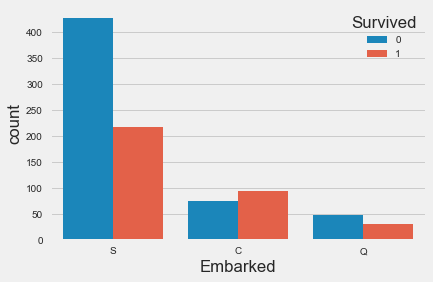

In [5]:
plt.style.use('fivethirtyeight')
sns.countplot(x='Embarked', data=train_data, hue='Survived') 
# looks like embarking at "S" lowers the likelihood of survival 

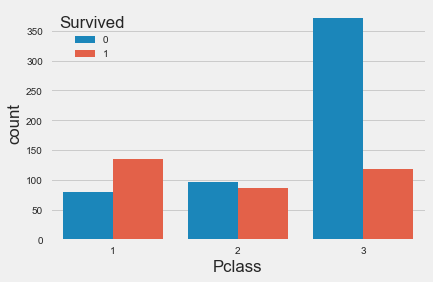

In [6]:
sns.countplot(x='Pclass', data=train_data, hue='Survived') 
# 3rd class passengers are less likely to survive

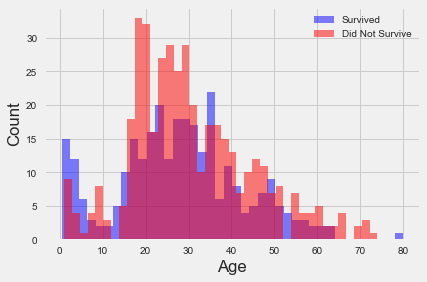

In [7]:
plt.figure()
train_data[train_data['Survived'] == 1]['Age'].hist(alpha=0.5, color='blue',
                                                bins=40, label='Survived')
train_data[train_data['Survived'] == 0]['Age'].hist(alpha=0.5, color='red', 
                                                bins = 40, label='Did Not Survive')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
# Passengers aged ~20-30 seem to be more likely to not survive
# otherwise, the ratio is close to 1:1

In [8]:
# get an idea of where which data are missing
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
# impute the age based on average within gender, class, and whether they had family (sibsp)
#train_data['Age'].mean().groupby
ages = train_data.groupby(['Pclass','Sex','SibSp'])['Age'].mean()
#ages[1]['female'][3] # returns 23.5
# large families have low age average, replace by smallest value for nan
ages.fillna(method='ffill', inplace=True) # forward fill Nan values ... reasonable for now
train_data.drop(['PassengerId', 'Name', 'Ticket','Cabin'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Name', 'Ticket','Cabin'], axis=1, inplace=True)

## Handle missing ages (by sex/class/sibsp)
+ Try with apply/lambda later

In [10]:
#train_data.fillna(method='ffill',inplace=True) ## OLD method
df_age = train_data[train_data['Age'].isnull()]
df_age.reset_index(drop=True, inplace=True)
imputed_age_list = []
# get ages from averaged list
for i in df_age.index.values:
    imputed_age_list.append(ages[df_age.iloc[i]['Pclass']][df_age.iloc[i]['Sex']][df_age.iloc[i]['SibSp']])
imputed_age_series = pd.Series(imputed_age_list)
df_age['Age'] = imputed_age_series
df_no_nan= train_data.dropna()
all_ages = pd.concat([df_no_nan, df_age])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [ ]:
df_age_test = test_data[test_data['Age'].isnull()]
df_age_test.reset_index(drop=True, inplace=True)
imputed_age_list = []
# get ages from averaged list
for i in df_age.index.values:
    imputed_age_list.append(ages[df_age_test.iloc[i]['Pclass']][df_age_test.iloc[i]['Sex']][df_age_test.iloc[i]['SibSp']])
imputed_age_series = pd.Series(imputed_age_list)
df_age['Age'] = imputed_age_series
df_no_nan= train_data.dropna()
all_ages = pd.concat([df_no_nan, df_age])

In [11]:
#from sklearn.preprocessing import Imputer
#values = train_data.values
#imputer = Imputer()
#transformed_values = imputer.fit_transform(values)
#print(np.isnan(transformed_values).sum())
all_ages.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [12]:
ages

Pclass  Sex     SibSp
1       female  0        34.000000
                1        36.441176
                2        30.666667
                3        23.500000
        male    0        42.738806
                1        38.481290
                2        47.000000
                3        19.000000
2       female  0        30.440476
                1        27.321429
                2        17.333333
                3        30.000000
        male    0        32.870597
                1        27.407407
                2        20.200000
3       female  0        22.866071
                1        27.232143
                2         9.083333
                3        11.000000
                4         8.333333
                5        16.000000
                8        16.000000
        male    0        29.012539
                1        23.057143
                2        28.666667
                3         5.333333
                4         6.416667
                5         8.75000

In [13]:
all_ages.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S


In [14]:
# Convert categorical data into 1 or 0
#final_data = pd.get_dummies(train_data, prefix=['Sex', 'Embarked'])
final_data = pd.get_dummies(all_ages, prefix=['Sex', 'Embarked'])
final_data.head(3)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1


## Missing values are now imputed
+ Ages imputed using ffill method. Implement a better method later
+ Continue with ML algorithms in scikit-learn
+ A better approach would be to estimate age based on similar passengersf
+ Example: average age based on mean groupy sex, class, sibsp

In [15]:
X = final_data.drop('Survived', axis=1)
y = final_data['Survived']

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

## Models to test
+ Logistic Regression
+ K-nearest neighbors
+ Random Forests

In [18]:
# let's test out a few models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression

In [19]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_logreg = logreg.predict(X_test)
print('Classification Report')
print(classification_report(y_test, y_logreg))
print('Confusion Matrix')
print(confusion_matrix(y_test, y_logreg))
print('Accuracy Score')
print(accuracy_score(y_test, y_logreg))

Classification Report
             precision    recall  f1-score   support

          0       0.85      0.87      0.86       172
          1       0.76      0.73      0.74        95

avg / total       0.82      0.82      0.82       267

Confusion Matrix
[[150  22]
 [ 26  69]]
Accuracy Score
0.820224719101


## Logistic Regression using StandardScaler

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [22]:
# Logistic Regression w/StandardScaler
logreg_ss = LogisticRegression()
logreg_ss.fit(X_train_std, y_train)
y_logreg_ss = logreg_ss.predict(X_test_std)
print('Classification Report')
print(classification_report(y_test, y_logreg_ss))
print('Confusion Matrix')
print(confusion_matrix(y_test, y_logreg_ss))
print('Accuracy Score')
print(accuracy_score(y_test, y_logreg_ss))

Classification Report
             precision    recall  f1-score   support

          0       0.86      0.87      0.86       172
          1       0.75      0.74      0.74        95

avg / total       0.82      0.82      0.82       267

Confusion Matrix
[[149  23]
 [ 25  70]]
Accuracy Score
0.820224719101


Performance is about the same with the use of StandardScaler

# K-Nearest Neighbors

In [23]:
# KNN - try a range of neighbor values
knn_accuracy = []
for i in range(1,101):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        knn_accuracy.append(accuracy_score(y_test, y_pred))
print("Maximum KNN Accuracy is: ", max(knn_accuracy), ' located at k-value: ', knn_accuracy.index(max(knn_accuracy))+1)

Maximum KNN Accuracy is:  0.7265917603  located at k-value:  25


## KNN with StandardScaler

In [24]:
knn_ss_accuracy = []
for i in range(1,101):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train_std, y_train)
        y_pred = knn.predict(X_test_std)
        knn_ss_accuracy.append(accuracy_score(y_test, y_pred))
print("Maximum KNN Accuracy is: ", max(knn_ss_accuracy), ' located at k-value: ', knn_ss_accuracy.index(max(knn_ss_accuracy))+1)

Maximum KNN Accuracy is:  0.838951310861  located at k-value:  14


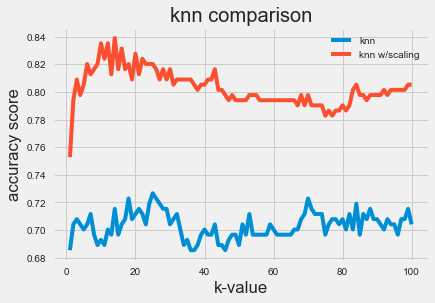

In [25]:
# plot both knn graphs on one figure
x_plt = range(1,101)
plt.plot(x_plt,knn_accuracy)
plt.plot(x_plt,knn_ss_accuracy)
plt.title('knn comparison')
plt.xlabel('k-value')
plt.ylabel('accuracy score')
plt.legend(['knn','knn w/scaling'])

# Random Forests

In [26]:
# Random Forests
rfc_accuracy=[]
n_est = [10,20,30,40,50,60,70,80,90,100]
for i in range(len(n_est)):
    rfc = RandomForestClassifier(n_estimators=n_est[i])
    rfc.fit(X_train, y_train)
    y_pred =rfc.predict(X_test)
    rfc_accuracy.append(accuracy_score(y_test,y_pred))
print("Maximum RFC Accuracy is: ", max(rfc_accuracy), ' located at n-est: ', (rfc_accuracy.index(max(rfc_accuracy))+1)*10)

Maximum RFC Accuracy is:  0.835205992509  located at n-est:  60


## Random Forests with StandardScaler

In [27]:
rfc_ss_accuracy=[]
n_est = [10,20,30,40,50,60,70,80,90,100]
for i in range(len(n_est)):
    rfc = RandomForestClassifier(n_estimators=n_est[i])
    rfc.fit(X_train_std, y_train)
    y_pred =rfc.predict(X_test_std)
    rfc_ss_accuracy.append(accuracy_score(y_test,y_pred))
print("Maximum RFC Accuracy is: ", max(rfc_ss_accuracy), ' located at n-est: ', (rfc_ss_accuracy.index(max(rfc_ss_accuracy))+1)*10)

Maximum RFC Accuracy is:  0.838951310861  located at n-est:  40


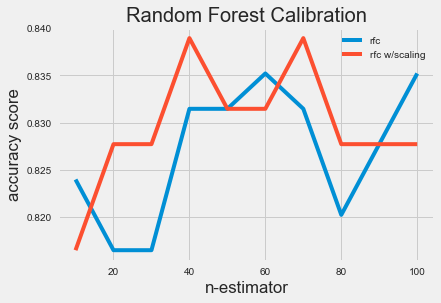

In [28]:
plt.plot(n_est,rfc_accuracy)
plt.plot(n_est,rfc_ss_accuracy)
plt.title('Random Forest Calibration')
plt.xlabel('n-estimator')
plt.ylabel('accuracy score')
plt.legend(['rfc', 'rfc w/scaling'])

# Support Vector Classification

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [30]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 
              'gamma': [1,0.1,0.01,0.001,0.0001], 
              'kernel': ['rbf']} 

In [31]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [32]:
grid.fit(X_train,y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....... C=0.1, gamma=1, kernel=rbf, score=0.605769, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....... C=0.1, gamma=1, kernel=rbf, score=0.605769, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....... C=0.1, gamma=1, kernel=rbf, score=0.606796, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ..... C=0.1, gamma=0.1, kernel=rbf, score=0.605769, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..... C=0.1, gamma=0.1, kernel=rbf, score=0.605769, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..... C=0.1, gamma=0.1, kernel=rbf, score=0.606796, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .... C=0.1, gamma=0.01, kernel=rbf, score=0.649038, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .... C=0.1, gamma=0.01, kernel=rbf, score=0.615385, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .... C=0.1, gamma=0.01, kernel=rbf, score=0.606796, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ... C=0.1, gamma=0.001, kernel=rbf, score=0.620192, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[CV] ...... C=1000, gamma=1, kernel=rbf, score=0.586538, total=   0.1s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ...... C=1000, gamma=1, kernel=rbf, score=0.606796, total=   0.1s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] .... C=1000, gamma=0.1, kernel=rbf, score=0.692308, total=   0.1s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] .... C=1000, gamma=0.1, kernel=rbf, score=0.634615, total=   0.1s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] .... C=1000, gamma=0.1, kernel=rbf, score=0.747573, total=   0.3s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ... C=1000, gamma=0.01, kernel=rbf, score=0.735577, total=   0.6s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ... C=1000, gamma=0.01, kernel=rbf, score=0.706731, total=   0.2s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    6.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [33]:
grid.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [34]:
grid.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [35]:
y_grid = grid.predict(X_test)

In [36]:
print('Classification Report')
print(classification_report(y_test, y_grid))
print('Confusion Matrix')
print(confusion_matrix(y_test, y_grid))
print('Accuracy Score')
print(accuracy_score(y_test, y_grid))

Classification Report
             precision    recall  f1-score   support

          0       0.86      0.83      0.84       172
          1       0.70      0.75      0.72        95

avg / total       0.80      0.80      0.80       267

Confusion Matrix
[[142  30]
 [ 24  71]]
Accuracy Score
0.797752808989


## SVC with StandardScaler

In [37]:
grid_ss = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
grid_ss.fit(X_train_std,y_train)
grid_ss.best_params_
grid_ss.best_estimator_
y_grid_ss = grid.predict(X_test_std)
#assess performance
print('Classification Report')
print(classification_report(y_test, y_grid_ss))
print('Confusion Matrix')
print(confusion_matrix(y_test, y_grid_ss))
print('Accuracy Score')
print(accuracy_score(y_test, y_grid_ss))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....... C=0.1, gamma=1, kernel=rbf, score=0.721154, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....... C=0.1, gamma=1, kernel=rbf, score=0.668269, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....... C=0.1, gamma=1, kernel=rbf, score=0.635922, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..... C=0.1, gamma=0.1, kernel=rbf, score=0.778846, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..... C=0.1, gamma=0.1, kernel=rbf, score=0.817308, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..... C=0.1, gamma=0.1, kernel=rbf, score=0.800971, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] .... C=0.1, gamma=0.01, kernel=rbf, score=0.740385, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .... C=0.1, gamma=0.01, kernel=rbf, score=0.798077, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .... C=0.1, gamma=0.01, kernel=rbf, score=0.776699, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ... C=0.1, gamma=0.001, kernel=rbf, score=0.605769, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ... C=0.1, gamma=0.001, kernel=rbf, score=0.605769, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ... C=0.1, gamma=0.001, kernel=rbf, score=0.606796, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .. C=0.1, gamma=0.0001, kernel=rbf, score=0.605769, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .

[CV] .... C=1000, gamma=0.1, kernel=rbf, score=0.788462, total=   0.4s
[CV] C=1000, gamma=0.1, kernel=rbf ...................................
[CV] .... C=1000, gamma=0.1, kernel=rbf, score=0.810680, total=   0.3s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ... C=1000, gamma=0.01, kernel=rbf, score=0.793269, total=   0.1s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ... C=1000, gamma=0.01, kernel=rbf, score=0.831731, total=   0.1s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ... C=1000, gamma=0.01, kernel=rbf, score=0.820388, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] .. C=1000, gamma=0.001, kernel=rbf, score=0.783654, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] .. C=1000, gamma=0.001, kernel=rbf, score=0.817308, total=   0.0s
[CV] C=1000, gamma=0.001, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    4.0s finished
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Summary 
+ Linear Regression - 82%/82%
+ K-Nearest Neighbors - 72%/84% with k=25, 14, respectively
+ Random Forests - 83%/83% with n_est=60, 40, respectively
+ Support Vector Classifier - 80%/35%

## Next steps
+ Try more common classifiers
+ Parameter tuning
+ k-fold crossvalidation
+ Better imputation for missing data in 'Age' column
+ functional programming to avoid repeating code (ss vs regular)

## Grouped average age imputation did not improve performance!
+ Earlier testing used forward filling to replace missing age values
+ Let's try k-fold cross validation
+ Use stratified k-fold
+ Stratification is the process of rearranging the data as to ensure each fold is a good representative of the whole
+ Let's do this for both logistic regression and knn as they are pretty simple to test

In [38]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [39]:
# fix the indices for X and y
X_kf = X.reset_index(drop=True)
y_kf = y.reset_index(drop=True)

In [40]:
kfold = StratifiedKFold(n_splits=10)

In [41]:
knn_kf = KNeighborsClassifier(n_neighbors=20)
logreg_kf = LogisticRegression()

In [42]:
scores = []
scores_lr = []
for train_index, test_index in kfold.split(X_kf,y_kf):
    xtrain, xtest = X_kf.iloc[train_index], X_kf.iloc[test_index]
    ytrain, ytest = y_kf[train_index], y_kf[test_index]
    # knn
    knn_kf.fit(xtrain, ytrain)
    score = knn_kf.score(xtest, ytest)
    scores.append(score)
    # logreg
    logreg_kf.fit(xtrain, ytrain)
    score_lr = logreg_kf.score(xtest, ytest)
    scores_lr.append(score_lr)
print(scores, scores_lr)

[0.5730337078651685, 0.6404494382022472, 0.797752808988764, 0.7303370786516854, 0.6629213483146067, 0.7528089887640449, 0.7415730337078652, 0.797752808988764, 0.6741573033707865, 0.76136363636363635] [0.7640449438202247, 0.7752808988764045, 0.8539325842696629, 0.7640449438202247, 0.797752808988764, 0.7752808988764045, 0.8089887640449438, 0.8089887640449438, 0.8314606741573034, 0.78409090909090906]


In [43]:
print('Mean accuracy for knn using KFold is {:0.2f}%'.format(np.mean(scores)*100))
print('Mean accuracy for logreg using KFold is {:0.2f}%'.format(np.mean(scores_lr)*100))

Mean accuracy for knn using KFold is 71.32%
Mean accuracy for logreg using KFold is 79.64%


In [44]:
# Try with scaling
# fix the indices for X and y with standardscaling
sc_cv=StandardScaler()
sc_cv.fit(X)
X_kf_std = sc_cv.transform(X)
y_kf_std = y.reset_index(drop=True)
knn_kf_ss = KNeighborsClassifier(n_neighbors=20)
logreg_kf_ss = LogisticRegression()

In [45]:
# try another way
acc_scores = []
ss_scores_lr = []
for train_index, test_index in kfold.split(X_kf_std,y_kf_std):
    xtrain, xtest = X_kf_std[train_index], X_kf_std[test_index]
    ytrain, ytest = y_kf_std[train_index], y_kf_std[test_index]
    #knn
    knn_kf_ss.fit(xtrain, ytrain)
    score = knn_kf_ss.score(xtest, ytest)
    acc_scores.append(score)
    #logreg
    logreg_kf_ss.fit(xtrain, ytrain)
    score_lr = logreg_kf_ss.score(xtest, ytest)
    ss_scores_lr.append(score_lr)
print(acc_scores, ss_scores_lr)

[0.8202247191011236, 0.7752808988764045, 0.8764044943820225, 0.8202247191011236, 0.8764044943820225, 0.8089887640449438, 0.7752808988764045, 0.7865168539325843, 0.8539325842696629, 0.79545454545454541] [0.7752808988764045, 0.7752808988764045, 0.8539325842696629, 0.7752808988764045, 0.797752808988764, 0.797752808988764, 0.7752808988764045, 0.8202247191011236, 0.8314606741573034, 0.80681818181818177]


In [46]:
print('Mean accuracy for knn using KFold is {:0.2f}%'.format(np.mean(acc_scores)*100))
print('Mean accuracy for logreg using KFold is {:0.2f}%'.format(np.mean(ss_scores_lr)*100))

Mean accuracy for knn using KFold is 81.89%
Mean accuracy for logreg using KFold is 80.09%


## Stratified KFold Cross Validation Results
+ Scaled and unscaled datasets used to predict passenger survival
+ k=10 used for both cases
+ 71% knn / 79% logreg  accuracy for unscaled data
+ 82% knn / 80% logreg accuracy for scaled data
+ Cross validation confirms earlier result for KNN performance
+ How much variance is there between each sample?

In [57]:
df_01 = pd.DataFrame(scores,columns=['Accuracy'])
df_02 = pd.DataFrame(scores_lr,columns=['Accuracy'])
df_03 = pd.DataFrame(acc_scores,columns=['Accuracy'])
df_04 = pd.DataFrame(ss_scores_lr,columns=['Accuracy'])

In [59]:
df_01['Algorithm'] = 'KNN'
df_01['Scaled'] = False
df_02['Algorithm'] = 'LogReg'
df_02['Scaled'] = False
df_03['Algorithm'] = 'KNN'
df_03['Scaled'] = True
df_04['Algorithm'] = 'LogReg'
df_04['Scaled'] = True

In [65]:
frames = [df_01, df_02, df_03, df_04]
all_scores = pd.concat(frames)

In [67]:
all_scores.reset_index(drop=True,inplace=True)

In [69]:
all_scores.head()

,Accuracy,Algorithm,Scaled
0,0.573034,KNN,False
1,0.640449,KNN,False
2,0.797753,KNN,False
3,0.730337,KNN,False
4,0.662921,KNN,False


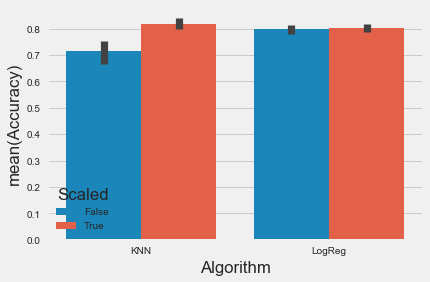

In [72]:
sns.barplot(x='Algorithm', y='Accuracy', hue='Scaled', data=all_scores)

## Conclusions
+ Scaled data outperforms unscaled data for KNN (significantly) and Logistic Regression (slightly)
+ KNN accuriacies are more varied than those for Logistic Regression from cross-validation
+ Re-calibrating 'k' for KNN with scaling might provide the most accurate predictor
+ Logistic Regression with StandardScaler is also a reasonable choice.

## Predict test set survival using Logistic Regression

In [ ]:
lr_test_set = LogisticRegression()
lr_test_set.fit(X_kf_std, y_kf_std)
predictions = lr_test_set.predict(X_TEST_SET_NAME)